In [5]:
import numpy as np
import pandas as pd # store in df
import re # for cleaning
# import os, sys
import string

from gensim import utils
from gensim.models import word2vec, keyedvectors
from gensim.test.utils import datapath, get_tmpfile, temporary_file
from gensim.models import LdaModel
from gensim.models import LsiModel
# from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
 
import pyLDAvis.gensim # python+lda+graph 

import spacy
nlp = spacy.load('en')

In [7]:
file = 'cleaned_workorders_nov15.csv'
df_file = pd.read_csv('cleaned_workorders_nov15.csv')
df_file.head()

,Unnamed: 0,HybridID,id,category_id,title,text,Author,ChoiceString,OtherFlag,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,0,735,35,7,NaN,Walk with a dog. . walk with my dog Can I or...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
1,1,749,49,7,NaN,. Repair Kitchen Window Window falls out whe...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
2,2,750,50,7,NaN,. Fire Alarm Light bulb & plastic cover The ...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
3,3,751,51,7,NaN,. Main Entrance Door lock needs to be replace...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN
4,4,752,52,7,NaN,. Window Screens For Front Bedroom and Midd...,LL,Other,1.0,NaN,NaN,NaN,NaN,NaN


In [18]:

cols = ['HybridID', 'text', 'ChoiceString']
df = pd.DataFrame(df_file, columns = cols)
# print(df['text'][:2500].tolist())

In [33]:
tags_list = ['<','<p>' ,'</p>' , '<*>', 'p ','/p',' p',
             '<b>', '</b>', '\n',
             '<ul>','</ul>','<li>',
             '</li>','<br>', '</br>', 
             '-','<strong>','</strong>',
             '<span*>','</span>','<a href*>',
             '</a>', '<em>','</em>', '&', 'nbsp', 
             '&nbsp', 'â', 'µ','<div>', '</div>', 'nan','/>', ';']

for tag in tags_list:
    df.text.replace(to_replace=tag, value='', regex=True, inplace=True)
df.head()

,HybridID,text,ChoiceString
0,735,Walk with a dog. walk with my doCan I order th...,Other
1,749,Repair Kitchen WindoWindow falls out when unlo...,Other
2,750,Fire Alarm Light bulb lastic coveThe fire alar...,Other
3,751,Main Entrance Door lock needs to be replaceMai...,Other
4,752,Window Screen For Front Bedroom and Middle Bed...,Other


In [60]:

other = df[df.ChoiceString == 'Other'].text
df_other = pd.DataFrame(other)
df_other.dropna(inplace=True)
df_other.drop_duplicates(inplace=True)
df_other.head()



,text
0,Walk with a dog. walk with my doCan I order th...
1,Repair Kitchen WindoWindow falls out when unlo...
2,Fire Alarm Light bulb lastic coveThe fire alar...
3,Main Entrance Door lock needs to be replaceMai...
4,Window Screen For Front Bedroom and Middle Bed...


In [59]:
hdf_other = df[df.ChoiceString == 'Household : Other'].text
hdf_other = pd.DataFrame(hdf_other)
hdf_other.dropna(inplace = True)
hdf_other.drop_duplicates(inplace = True)

hdf_other.head()

,text
16249,Dry wal
16250,.
16252,Furnace filter change/Interior maintece insp...
16253,Hi PattI have noticed recently in the small...
16254,divThere's leaking in the toilet ceiling fro...


In [62]:

tokens = word_tokenize(hdf_other.text.to_string())  
tokens = [w.lower() for w in tokens]              # convert to lower case
table = str.maketrans('', '', string.punctuation) # remove punctuation from each word
stripped = [w.translate(table) for w in tokens]   # remove remaining tokens that are not alphabetic

words = [word for word in stripped if word.isalpha()]

stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words] # filter out stop words
# words = [t for t in words if not t in tags_list]

texts = [words]
texts[:50]


[['dry',
  'wal',
  'furnace',
  'filter',
  'changeinterior',
  'maintece',
  'insp',
  'hi',
  'noticed',
  'recently',
  'small',
  'divthere',
  'leaking',
  'toilet',
  'ceiling',
  'fro',
  'main',
  'window',
  'glass',
  'cracked',
  'exterior',
  'handrail',
  'rspan',
  'style',
  'letterspacin',
  'shower',
  'screen',
  'repair',
  'shower',
  'screen',
  'needs',
  'repa',
  'steam',
  'valve',
  'replacement',
  'hand',
  'sink',
  'ventilation',
  'fan',
  'replacement',
  'remodel',
  'bath',
  'street',
  'front',
  'co',
  'reseal',
  'bathtubs',
  'units',
  'toilet',
  'leaking',
  'replace',
  'front',
  'main',
  'entrance',
  'dooexisting',
  'replace',
  'bathroom',
  'bedroom',
  'window',
  'make',
  'home',
  'movein',
  'ready',
  'repair',
  'possibly',
  'replace',
  'front',
  'door',
  'locks',
  'hvac',
  'repair',
  'floor',
  'b',
  'oven',
  'nt',
  'working',
  'tet',
  'called',
  'monday',
  'garage',
  'door',
  'insulation',
  'needs',
  'replac

In [63]:
dictionary = Dictionary(texts)
# dictionary = dictionary.filter_tokens('water')
corpus = [dictionary.doc2bow(text) for text in texts]
#corpus
# print(dictionary.token2id)

In [37]:
import warnings
warnings.filterwarnings('ignore')

# Topic Modeling with Latent Dirichlet Allocation (LDA)


There are two layers in this model — documents and tokens — and the size or dimensionality of the document vectors is the number of tokens in the corpus vocabulary. This approach has a number of disadvantages:

* Document vectors tend to be large (one dimension for each token ⇒ lots of dimensions)
* They also tend to be very sparse. Any given document only contains a small fraction of all tokens in the vocabulary, so most values in the document's token vector are 0.
* The dimensions are fully independent from each other — there's no sense of connection between related tokens, such as knife and fork.

## LDA injects a third layer into this conceptual model. 

    Documents are represented as a mixture of a pre-defined number of topics, and the topics are represented as a mixture of the individual tokens in the vocabulary. The number of topics is a model hyper-parameter selected by me. 

### LDA makes a prior assumption that the (document, topic) and (topic, token) mixtures follow Dirichlet probability distributions. 



## This assumption encourages documents to consist mostly of a handful of topics, and topics to consist mostly of a modest set of the tokens.
   
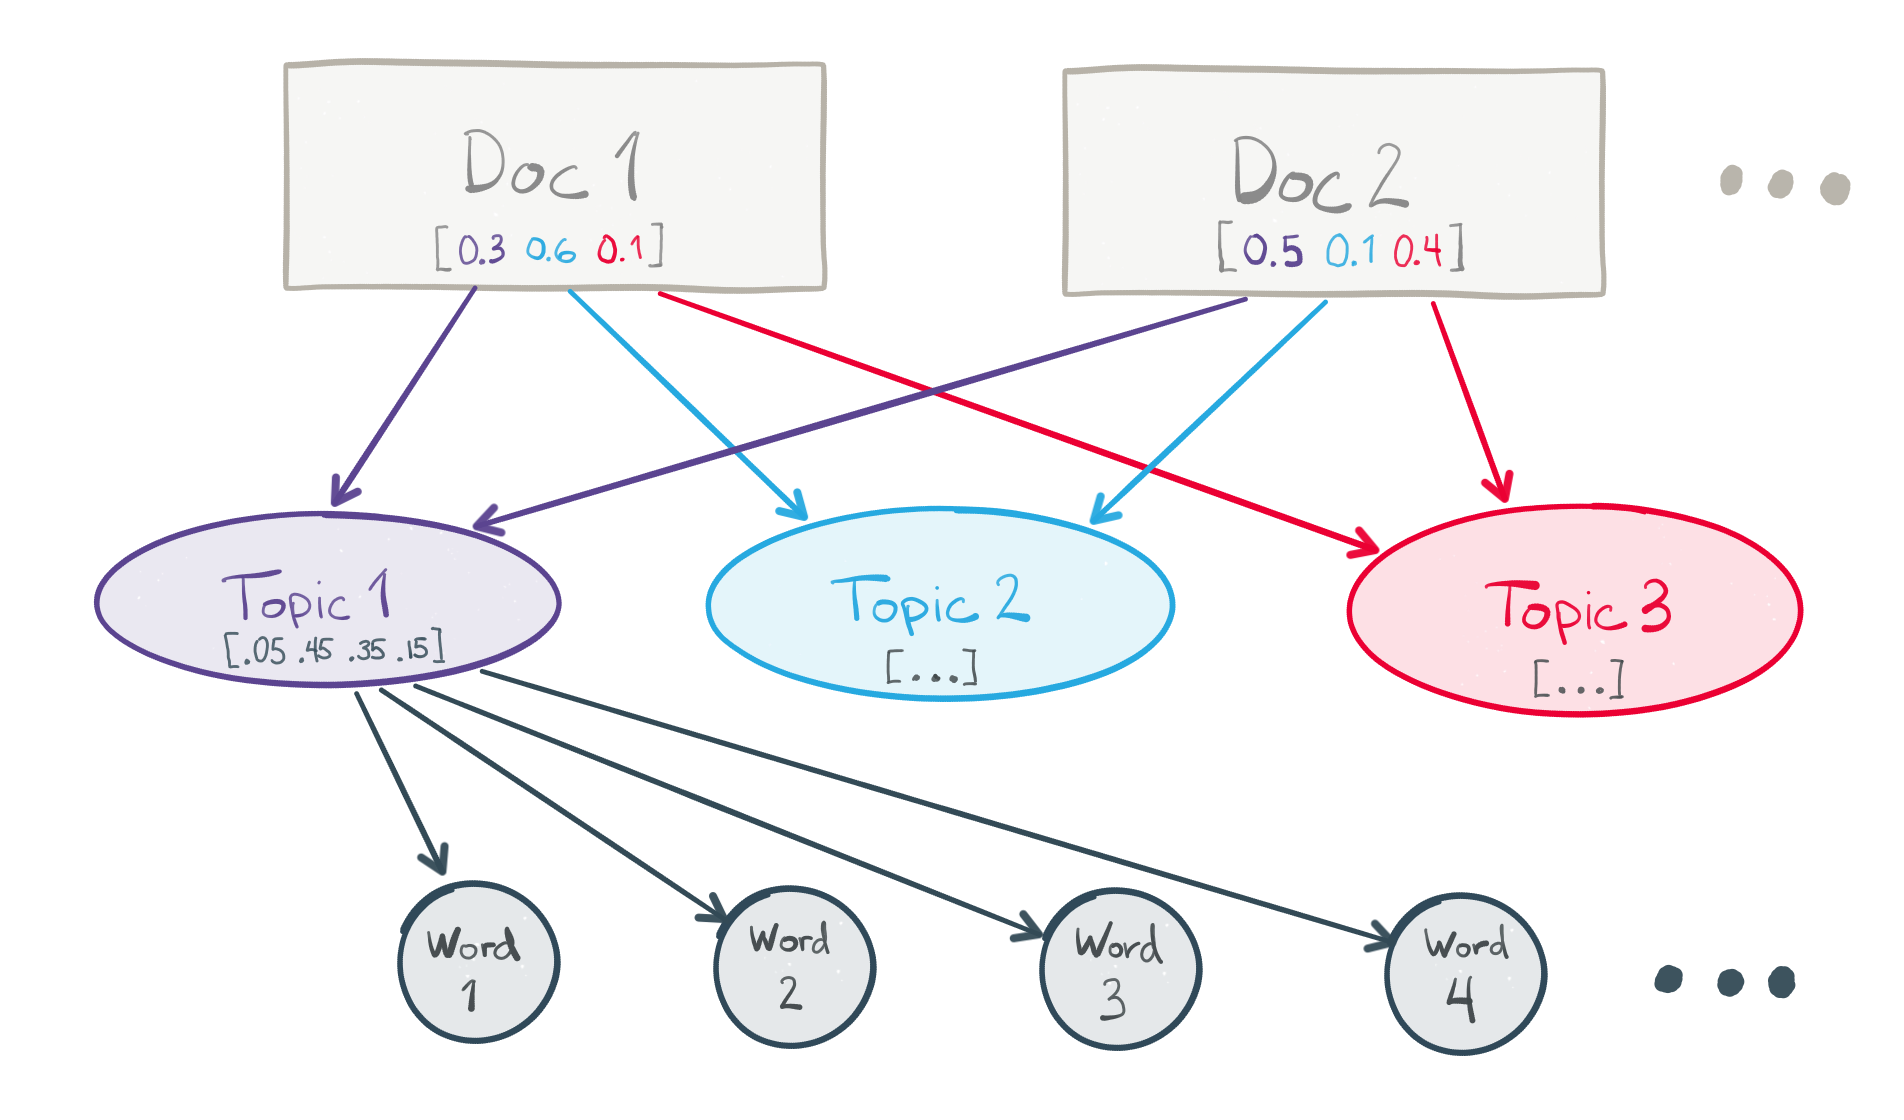
[Source](http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb#topic=0&lambda=1&term=)

In [64]:
np.random.seed(1) # setting random seed to get the same results each time.
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=3)


In [65]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.003741  0.001811       1        1  87.73761
2     -0.001127 -0.002601       2        1  12.25974
0      0.004869  0.000790       3        1   0.00265, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
1068  Default  191.000000        door  191.000000  30.0000  30.0000
3209  Default  167.000000       smoke  167.000000  29.0000  29.0000
314   Default  140.000000    bathroom  140.000000  28.0000  28.0000
2873  Default  125.000000     replace  125.000000  27.0000  27.0000
2847  Default  143.000000      repair  143.000000  26.0000  26.0000
2406  Default  115.000000       needs  115.000000  25.0000  25.0000
3727  Default  112.000000        unit  112.000000  24.0000  24.0000
1985  Default   96.000000     kitchen   96.000000  23.0000  23.0000
1860  Default  109.000000     install  109.000000  22.0000  22.0000
616   Default   93.000000     ceiling   93.000000  21.0000  21.0000
2400  Default   88.000000        need   88.000000  20.0000  20.0000
2424  Default  106.000000         new  106.000000  19.0000  19.0000
3955  Default   82.000000      window   82.000000  18.0000  18.0000
362   Default   72.000000     bedroom   72.000000  17.0000  17.0000
257   Default   70.000000        back   70.000000  16.0000  16.0000
1002  Default   64.000000    detector   64.000000  15.0000  15.0000
56    Default   73.000000         air   73.000000  14.0000  14.0000
2971  Default   74.000000        room   74.000000  13.0000  13.0000
1389  Default   56.000000         fix   56.000000  12.0000  12.0000
1846  Default   62.000000  inspection   62.000000  11.0000  11.0000
1498  Default   71.000000       front   71.000000  10.0000  10.0000
4000  Default   62.000000     working   62.000000   9.0000   9.0000
691   Default   67.000000       clean   67.000000   8.0000   8.0000
1417  Default   54.000000       floor   54.000000   7.0000   7.0000
698   Default   44.000000    cleaning   44.000000   6.0000   6.0000
3151  Default   60.000000      shower   60.000000   5.0000   5.0000
3490  Default   58.000000         tet   58.000000   4.0000   4.0000
487   Default   56.000000      broken   56.000000   3.0000   3.0000
715   Default   59.000000      closet   59.000000   2.0000   2.0000
3857  Default   47.000000        wall   47.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1763   Topic3    0.001240       house   46.174107   0.0138  -5.7563
732    Topic3    0.000215        code    5.872809   0.3225  -7.5097
2406   Topic3    0.002695       needs  115.804253  -0.1296  -4.9802
2400   Topic3    0.002155        need   88.931793  -0.0893  -5.2040
1541   Topic3    0.000806         gas   28.120169   0.0783  -6.1877
3857   Topic3    0.001253        wall   47.788960  -0.0107  -5.7464
2457   Topic3    0.000867          nt   30.963648   0.0549  -6.1148
1530   Topic3    0.000792      garage   28.027769   0.0647  -6.2047
362    Topic3    0.001740     bedroom   72.386024  -0.0976  -5.4181
1985   Topic3    0.002192     kitchen   96.653206  -0.1555  -5.1869
2130   Topic3    0.001144      living   43.906803  -0.0166  -5.8371
257    Topic3    0.001679        back   70.194313  -0.1020  -5.4533
4000   Topic3    0.001532     working   62.830563  -0.0833  -5.5454
3955   Topic3    0.001903      window   82.533066  -0.1388  -5.3281
3727   Topic3    0.002391        unit  112.318581  -0.2187  -5.0999
314    Topic3    0.002819    bathroom  140.696198  -0.2796  -4.9355
616    Topic3    0.002006     ceiling   93.944901  -0.2160  -5.2758
1860   Topic3    0.002236     install  109.286560  -0.2584  -5.1670
3209   Topic3    0.002910       smoke  167.979599  -0.4250  -4.9037
2971   Topic3    0.001561        room   74.122726  -0.2295  -5.5263
2847   Topic3    0.002409      repair  143.468643  -0.4562  -5.0926
1846   Topic3    0.0

# Wait, what am I looking at again?

#### There are a lot of moving parts in the visualization. Here's a brief summary:

* On the left, there is a plot of the __"distance" between all of the topics__ (labeled as the Intertopic Distance Map)
    * The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally __similar should be appear close together on the plot__, while dissimilar topics should appear far apart.
    * The relative __size of a topic's circle in the plot corresponds to the relative frequency of the topic__ in the corpus.
    * An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.
* On the right, there is a bar chart showing __top terms__.
    * When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.
    * When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λ, which can be adjusted with a slider above the bar chart.
        * Setting the λ parameter close to __1.0__ (the default) will rank the terms solely according to their __probability within the topic__.
        * Setting λ close to 0.0 will rank the terms solely according to their __"distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics__.
        * Setting λ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.
        
* Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found [here](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf). Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaMulticore object and pyLDAvis' visualization, you have to dig through the terms manually.

## Analyzing our LDA model

The interactive visualization pyLDAvis produces is helpful for both:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the λ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In our plot, there is a stark divide along the y-axis, with 2 small topics to the left and most of the remaining 48 far to the right. Inspecting the two outlier topics provides a plausible explanation: both topics contain names/jibberish/non-english words, while most of the rest of the topics are in English and somewhat related. 

I was hoping that one of the main attributes that distinguish the maintenence requests in the dataset from one another might be something like non-english words, however, we can only say a distinguishing attribute in the MR data is non-words and typos from english words.


On the right side the x-axis cuts through call them "super-topics"  These super-topics correlate reasonably well with the pattern we'd noticed while naming the topics:



So, in addition to the 50 direct topics the model has learned, our analysis suggests a higher-level pattern in the data. 

### Tenants, PM's and landlords in the MR dataset tend to include three main things in their requests, in general:

    (1) the location (kitchen, bedroom, bathroom) 
    (2) the action that needs to be taken (repaired,replaced, installed, changed, new) and 
    (3) the things that needs the action (sink, ac,door, ceiling ect). 


## Describing text with LDA

Beyond data exploration, one of the key uses for an LDA model is _providing a compact, quantitative description of natural language text_. Once an LDA model has been trained, it can be used to represent free text as a mixture of the topics the model learned from the original corpus. This mixture can be interpreted as a __probability distribution__ across the topics, so the LDA representation of a paragraph of text might look like 50% Topic A, 20% Topic B, 20% Topic C, and 10% Topic D.

To use an LDA model to generate a vector representation of new text, you'll need to apply any text preprocessing steps you used on the model's training corpus to the new text, too. For our model, the preprocessing steps we used include:



## HDP the Hierarchical Dirichlet Process is an *unsupervised topic model* which figures out the number of topics on it's own.



In [11]:
from gensim.models import HdpModel
from gensim.models.wrappers import LdaMallet
import pyLDAvis.gensim

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()


[(0,
  '0.014*door + 0.010*kitchen + 0.010*bathroom + 0.009*needs + 0.009*leaking + 0.008*working + 0.008*sink + 0.008*relace + 0.008*ac + 0.008*need + 0.007*unit + 0.007*u + 0.007*toilet + 0.007*new + 0.007*tet + 0.006*front + 0.006*light + 0.006*reair + 0.006*leak + 0.006*air'),
 (1,
  '0.000*fuel + 0.000*underhous + 0.000*orhp + 0.000*bowl + 0.000*joes + 0.000*tye + 0.000*asdasd + 0.000*kiln + 0.000*orefrigerator + 0.000*leakindown + 0.000*doggy + 0.000*showeringis + 0.000*artreat + 0.000*sudden + 0.000*fabricador + 0.000*collase + 0.000*cactus + 0.000*debirs + 0.000*bdamage + 0.000*weeks'),
 (2,
  '0.000*doowooden + 0.000*stu + 0.000*vinyl + 0.000*igni + 0.000*office + 0.000*wees + 0.000*te + 0.000*plumbingac + 0.000*blackout + 0.000*controller + 0.000*stream + 0.000*kemit + 0.000*hayden + 0.000*gle + 0.000*bedro + 0.000*squeak + 0.000*circular + 0.000*grr + 0.000*nonexistent + 0.000*lindsay'),
 (3,
  '0.000*unlock + 0.000*photograhs + 0.000*jaren + 0.000*niether + 0.000*pressure +

In [12]:
# pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=              x             y  topics  cluster          Freq
topic                                                       
0      0.363388  6.897733e-07       1        1  9.999980e+01
1     -0.002110  1.913474e-05       2        1  1.025562e-04
2     -0.002557  9.240920e-04       3        1  4.886982e-05
3     -0.002772  7.513239e-04       4        1  2.441558e-05
4     -0.002080  2.505031e-04       5        1  1.220779e-05
5     -0.002876 -6.701646e-04       6        1  6.103894e-06
6     -0.002673  2.458053e-04       7        1  3.051947e-06
7     -0.002640 -3.072076e-04       8        1  1.525974e-06
8     -0.002363 -5.492973e-04       9        1  7.629868e-07
9     -0.002554 -7.378605e-04      10        1  3.814934e-07
10    -0.002620 -1.872176e-04      11        1  1.907467e-07
11    -0.002499  9.858921e-04      12        1  9.537335e-08
12    -0.002711 -1.540643e-04      13        1  4.768667e-08
13    -0.002219  2.682839e-04      14        1  2.384334e-08
14    -0.002310 -1.754999e-03      15        1  1.192167e-08
15    -0.002481 -5.447848e-05      16        1  5.960834e-09
16    -0.002075  3.695513e-04      17        1  2.980417e-09
17    -0.002418 -6.347675e-05      18        1  1.490209e-09
18    -0.002785  4.964056e-04      19        1  7.451043e-10
19    -0.003086 -2.651624e-05      20        1  3.725521e-10
20    -0.002573 -4.823791e-04      21        1  1.862761e-10
21    -0.003088  2.392486e-04      22        1  9.313804e-11
22    -0.002277 -5.410194e-04      23        1  4.656902e-11
23    -0.001973 -4.587263e-04      24        1  2.328451e-11
24    -0.002449  5.746329e-04      25        1  1.164225e-11
25    -0.002609 -5.830639e-04      26        1  5.821127e-12
26    -0.002627  4.773592e-04      27        1  2.910564e-12
27    -0.002335 -8.713359e-04      28        1  1.455282e-12
28    -0.002613 -3.994858e-04      29        1  7.276409e-13
29    -0.003007  3.290459e-04      30        1  3.638205e-13
...         ...           ...     ...      ...           ...
120   -0.002514 -5.460938e-05     121        1  1.469459e-40
121   -0.002946 -7.971274e-04     122        1  7.347296e-41
122   -0.002933  3.680346e-04     123        1  3.673648e-41
123   -0.002847  4.498964e-04     124        1  1.836824e-41
124   -0.002540  4.365755e-04     125        1  9.184119e-42
125   -0.001601  1.103581e-04     126        1  4.592060e-42
126   -0.002768 -7.040268e-04     127        1  2.296030e-42
127   -0.002456  2.274303e-04     128        1  1.148015e-42
128   -0.002676  4.813250e-05     129        1  5.740075e-43
129   -0.002417 -9.555382e-05     130        1  2.870037e-43
130   -0.002090 -1.128873e-03     131        1  1.435019e-43
131   -0.002411  4.016245e-04     132        1  7.175093e-44
132   -0.002336  7.708925e-05     133        1  3.587547e-44
133   -0.002985 -3.987724e-05     134        1  1.793773e-44
134   -0.002682  1.397442e-04     135        1  8.968867e-45
135   -0.001684  4.620482e-04     136        1  4.484433e-45
136   -0.002644 -3.513013e-04     137        1  2.242217e-45
137   -0.002737 -7.176598e-04     138        1  1.121108e-45
138   -0.002144  2.876298e-04     139        1  5.605542e-46
139   -0.002348  3.525850e-04     140        1  2.802771e-46
140   -0.002804 -2.671328e-04     141        1  1.401385e-46
141   -0.002483  6.466612e-05     142        1  7.006927e-47
142   -0.002050  1.894589e-05     143        1  3.503464e-47
143   -0.002611  1.758571e-04     144        1  1.751732e-47
144   -0.002947 -2.491260e-04     145        1  8.758659e-48
145   -0.002690 -1.563015e-05     146        1  4.379329e-48
146   -0.001705 -2.936776e-04     147        1  2.189665e-48
147   -0.002604  1.163254e-04     148        1  1.094832e-48
148   -0.002030  5.246161e-04     149        1  5.474162e-49
149   -0.002712  3.352524e-04     150        1  5.474162e-49

[150 rows x 5 columns], topic_info=       Category          Freq             Term        Total  loglift  logprob
term        

## LSI : Latent Semantic Indexing 
 
It is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [13]:
model_lsi = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
model_lsi.show_topics(num_topics=10)  # Showing only the top 5 topics

[(0,
  '0.302*"door" + 0.218*"kitchen" + 0.210*"bathroom" + 0.192*"needs" + 0.185*"leaking" + 0.178*"working" + 0.178*"sink" + 0.176*"relace" + 0.168*"ac" + 0.168*"need"')]

In [17]:
# df['topic_names'] = df['ChoiceString'].copy

# print(topic_names)

In [24]:
# dictionary.keys = topic_names
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Doc2Vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dictionary)]

# d2v_model = Doc2Vec(documents, vector_size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
#                 alpha=0.025, min_alpha=0.001)
# parsed_mr = nlp(str(texts[0:90000]))
# for num, entity in enumerate(parsed_mr.ents):
#     print ('Entity {}:'.format(num + 1), entity, '-', entity.label_)
#     print ('')
# pyLDAvis.gensim.prepare(ldamodel.get_term_topics(), corpus, dictionary)
# d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [80]:
def lda_description(text_list, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    text_list = hdf_other.text.to_string()
    # parse the review text with spaCy
    parsed_mr = nlp(text_list)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_mr = [token.lemma_ for token in parsed_mr
                      if not token.is_punct]
    
    # apply the first-order and secord-order phrase models
    bigram_mr = bigram_model[unigram_mr]
    trigram_mr = trigram_model[bigram_mr]
    
    # remove any remaining stopwords
    trigram_mr = [term for term in text_list
                      if not term in spacy.en.STOPWORDS]
    
    # create a bag-of-words representation
    mr_bow = trigram_dictionary.doc2bow(text_list)
    
    # create an LDA representation
    mr_lda = lda[mr_bow]
    
    # sort with the most highly related topics first
#     mr_lda = np.sort(mr_lda, key=lambda (topic_number, freq): -freq)
    
    for topic_number, freq in review_lda:
        if freq < min_topic_freq:
            break
            
lda_description(hdf_other.text.to_string(), min_topic_freq=0.05)

NameError: name 'bigram_model' is not defined

In [30]:
# lda_description(texts)


In [38]:
# import bokeh.plotting as bp
# from bokeh.models import HoverTool, BoxSelectTool
# from bokeh.plotting import figure, show, output_notebook
# output_notebook()
# plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
#     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
#     x_axis_type=None, y_axis_type=None, min_border=1)

# word_vec = [ldamodel[w] for w in list(ldamodel[:5000])]

# from sklearn.manifold import TSNE
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
# tsne_w2v = tsne_model.fit_transform(word_vec)

# tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
# tsne_df['words'] = list(d2v_model.wv.vocab.keys())[:500]

# plot_tfidf.scatter(x='x', y='y', source=tsne_df)
# hover = plot_tfidf.select(dict(type=HoverTool))
# hover.tooltips={"word": "@words"}
# show(plot_tfidf)